# Machine Learning Regresssions
***

#### Table of Contents:
- [Library Imports](#Library-Imports)
- [Preprocessing the Data](#Preprocessing-the-Data)
- [Models](#Models)
    - [Elastic Net](#Elastic-Net)
    - [Support Vector Regression](#Support-Vector-Regression)
    - [Ridge](#Ridge)
- [Looping Through the Data](#Looping-Through-the-Data)
- [Residual Plots](#Residual-Plots)
- [Results](#Results)



### Library Imports
***

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import ElasticNet
from sklearn.svm import LinearSVR
from statsmodels.regression.rolling import RollingOLS
from sklearn.linear_model import Ridge

from os import listdir
from os.path import isfile, join

from scipy.stats import normaltest

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Preprocessing the Data
***

In [2]:
# This function removes highly correlated variables within the dataset. The function looks at the 
# Pearson Correlation Coefficient between every pair of variables in the dataset and returns all 
# of those between .8 and .999. While working with data from different companies, I found that by
# removing the first 90% of correlated variables within the DataFrame, in almost all cases, there
# were no longer correlations within the dataset.

def remove_corrs(df):
    
    # create a DataFrame with all the of the correlation coefficients, and then stack the pairings.
    corrs = df.corr().stack().reset_index()
    corrs.columns = ['1','2','R2']
    # create a temoporary DataFrame that contains all the pairs of variables that have a correlation
    # between .8 and .999. Because the .corr() method returns the pairings in both directions, I only
    # look at half of the cells because of duplicates.
    temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
    correlations = temp[temp.index % 2 == 0]
    
    # look at how many times each variable shows up in the correlation column
    corr_index = correlations['1'].value_counts().index
    # delete the first 90% of the variables. This generally removes the columns that are most correlated with the others. 
    to_drop = round(len(corr_index)*.9)
    
    df2 = df.drop(corr_index[:to_drop], axis = 1)
    
    return df2

In [3]:
# This function preprocesses my data so it is ready for distanced based regressions.

def preprocess_data(df, target_var = 'close'):
    
    df.index = pd.to_datetime(df.index)
    
    # Here, I shift all the independent variables back one day in order to make sure there is
    # no data leakage. Because we're trying to predict closing price, we can't know many of
    # things that happen throughout the day we're trying to predict.
    X = df.shift(1).dropna()
    
    # This is the function described above.
    X_data = remove_corrs(X)

    # Because I am running a regression, I can use a continuous variable as my dependent variable.
    # Ideally, my algorithim can predict the closing price at the end of the day with accuracy.
    y = df[target_var].iloc[1:]
    
    # Do a train test split with the first 80% of the data being the training set and the last 20%
    # as the testing set.
    X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = .2, random_state = 42)
    
    # Because I am doing distance based regressions, I need to scale the data so that variables with
    # higher absolute values don't dominate the metrics.
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_test_scaled = ss.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns).set_index(X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns).set_index(X_test.index)
    
    return X_train, X_test, y_train, y_test

In [13]:
def model_plot(y_train, y_test, y_hat_train, y_hat_test):

    fig, ax = plt.subplots(3, figsize = (24,24))
    ax0_x = y_train.index
    ax0_y = (y_hat_train - y_train)/y_train
    ax[0].scatter(ax0_x,ax0_y)
    ax[0].yaxis.set_major_formatter('{x:1,.2%}')
    ax[0].axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0)
    ax[0].set_title('Training Residuals as a Percentage of Closing Price')

    ax1_x = y_test.index 
    ax1_y1 = y_test
    ax1_y2 = y_hat_test
    ax[1].scatter(ax1_x, ax1_y1, linewidth = 3)
    ax[1].scatter(ax1_x, ax1_y2)
    ax[1].set_title('Predicted Price vs. Actual Price')
    ax[1].yaxis.set_major_formatter('${x}')
    ax[1].legend(['Observed Values', 'Predicted Values'])

    ax2_x = y_test.index
    ax2_y = (y_hat_test - y_test)/y_test
    ax[2].scatter(ax2_x,ax2_y)
    ax[2].yaxis.set_major_formatter('{x:1,.2%}')
    ax[2].axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0)
    ax[2].set_title('Test Residuals as a Percentage of Closing Price')

## Models
***

### Elastic Net

In [15]:
def EN_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'l1_ratio': [.01,.25,.5,.75,1],
    'alpha': [.01,.25,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    en = ElasticNet(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=en, param_grid=grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()

    # Score the train and test sets.
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)
    
    print(f'Train RMSE: {train_score}')
    print(f'Mean Cross-Val Score: {cv_results.mean()}')
    print(f'Test RMSE: {test_score}')

    # Create a DataFrame that has the predictions for the given days of the train set.
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happened on the given day.
    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    # Create a DataFrame that has the predictions for the given days of the test set.
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    # Compare the direction of the predicted value with what actually happend on the given day. 
    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)

    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
    
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')
    
    model_plot(y_train, y_test, y_hat_train, y_hat_test)

    results = ['Elastic Net', train_score, cv_results, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Support Vector Regression

In [6]:
def SVR_test(X_train, X_test, y_train, y_test, cv=5):
    
    svr = LinearSVR(random_state = 42, max_iter = 10e5)
    svrmodel = svr.fit(X_train, y_train)
    
    train_score = svr.score(X_train, y_train)
    y_hat_train = svr.predict(X_train)
    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    train_cv_score = cross_val_score(svrmodel, X_train, y_train, scoring = 'neg_root_mean_squared_error').mean()
    
    test_score = svr.score(X_test, y_test)
    y_hat_test = svr.predict(X_test)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')

    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    model_plot(y_train, y_test, y_hat_train, y_hat_test)
    
    results = ['SVR', train_score, train_cv_score, test_score, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Ridge

In [7]:
def Ridge_test(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
    'alpha': [.01, .05, .1,.5,.75,1],
    }
    
    # Instantiate & fit RidgeRegression
    ridge = Ridge(random_state = 42, max_iter = 10e5)
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=ridge, param_grid=grid, cv=cv, scoring='r2', n_jobs = -1)
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    ridge_params = gs.best_params_
    
    # Create prediction variable using test data
    y_hat_train = gs.predict(X_train)
    y_hat_test = gs.predict(X_test)

    # Run cross-validate score with cv folds from function parameter
    train_cv_score = cross_val_score(gs, X_train, y_train, cv=cv, scoring = 'neg_root_mean_squared_error').mean()
    
    # Run and print accuracy, recall, precision and f1 scores
    train_score = gs.score(X_train, y_train)
    test_score = gs.score(X_test, y_test)

    train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
    test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)
    
    preds_train = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index), df.day_direction], axis = 1)
    preds_train.dropna(inplace = True)

    preds_train['direction'] = np.where(preds_train.predictions > preds_train.close.shift(1), 1, 0)
    preds_train['correct'] = np.where(preds_train['direction'] == preds_train['day_direction'], 1, 0)
    train_accuracy = preds_train['correct'].value_counts(normalize = True)
    
    preds_test = pd.concat([y_test, pd.DataFrame(y_hat_test, columns = ['predictions'], index = y_test.index), df.day_direction], axis = 1)
    preds_test.dropna(inplace = True)

    preds_test['direction'] = np.where(preds_test.predictions > preds_test.close.shift(1), 1, 0)
    preds_test['correct'] = np.where(preds_test['direction'] == preds_test['day_direction'], 1, 0)
    test_accuracy = preds_test['correct'].value_counts(normalize = True)
    
    print(f'Train RMSE : {train_rmse}')
    print(f'Mean Train Cross-Validation RMSE: {train_cv_score}')
    print(f'Test RMSE : {test_rmse}')
    print(f'Train accuracy: {train_accuracy[1]}')
    print(f'Test accuracy: {test_accuracy[1]}')
 
    normality_score = normaltest(y_hat_train - y_train)[1]
    print(f'Normality score: {normality_score}')

    model_plot(y_train, y_test, y_hat_train, y_hat_test)
    
    results = ['Ridge', train_rmse, train_cv_score, test_rmse, train_accuracy[1], test_accuracy[1], normality_score]
    
    return results

### Looping Through the Data
***
This is the code that was used to loop through the data and get the final csv files with the regression results. Due to time and processing power constraints, the code was run using [Google Colab](#https://colab.research.google.com/?utm_source=scs-index).

In [8]:
# get the files in the Formatted Data folder.
files = [f for f in listdir('..\FormattedData')]

#remove the ipynb checkpoint file
files.pop(0)

# create a list of companies that can be analyzed.
companies = []
for i in files:
    company = i.split('.')[0]
    companies.append(company)

# create a list of random companies to analyze from within the formatted companies
test_companies = np.random.choice(companies, 5, replace = False)

In [9]:
# loop through the companies and perform the different alogrithims. Create a
# list of DataFrames that can then be used to compared results across different
# companies and algorithms.

#results = []

#for c in test_companies:
#    csv_for_df = f'FormattedData/{c}.csv'
#    df = pd.read_csv(csv_for_df, index_col = 0)
#    X_train, X_test, y_train, y_test = preprocess_data(df)
#    en_results = EN_test(X_train, X_test, y_train, y_test)
#    svr_results = SVR_test(X_train, X_test, y_train, y_test)
#    ridge_results = Ridge_test(X_train, X_test, y_train, y_test)
#    c_results = pd.DataFrame([en_results, svr_results, ridge_results],
#            columns = ['Model Type', 'Train RMSE', 'Cross-Val RMSE', 'Test RMSE', 
#             'Train Accuracy', 'Test Accuracy', 'Normality of Residuals'])
#    c_results['company'] = c.split('_')[0]
#    results.append(c_results)

In [10]:
df = pd.read_csv('../FormattedData/CFG_formatted.csv', index_col = 0)

Train RMSE: -2.9621970138248233
Mean Cross-Val Score: -3.0996605247132374
Test RMSE: -3.02709505078902
Train accuracy: 0.5091487669053302
Test accuracy: 0.5301587301587302
Normality score: 0.3792794712974976
Train RMSE : 12.363537445480937
Mean Train Cross-Validation RMSE: -20.206186413858834
Test RMSE : 11.844632948716251
Train accuracy: 0.5163086714399363
Test accuracy: 0.46984126984126984
Normality score: 1.452464728063491e-78
Train RMSE : 2.9494799780706544
Mean Train Cross-Validation RMSE: -3.0993937304394428
Test RMSE : 3.0430681624869464
Train accuracy: 0.5027844073190135
Test accuracy: 0.5428571428571428
Normality score: 0.35239038217734364


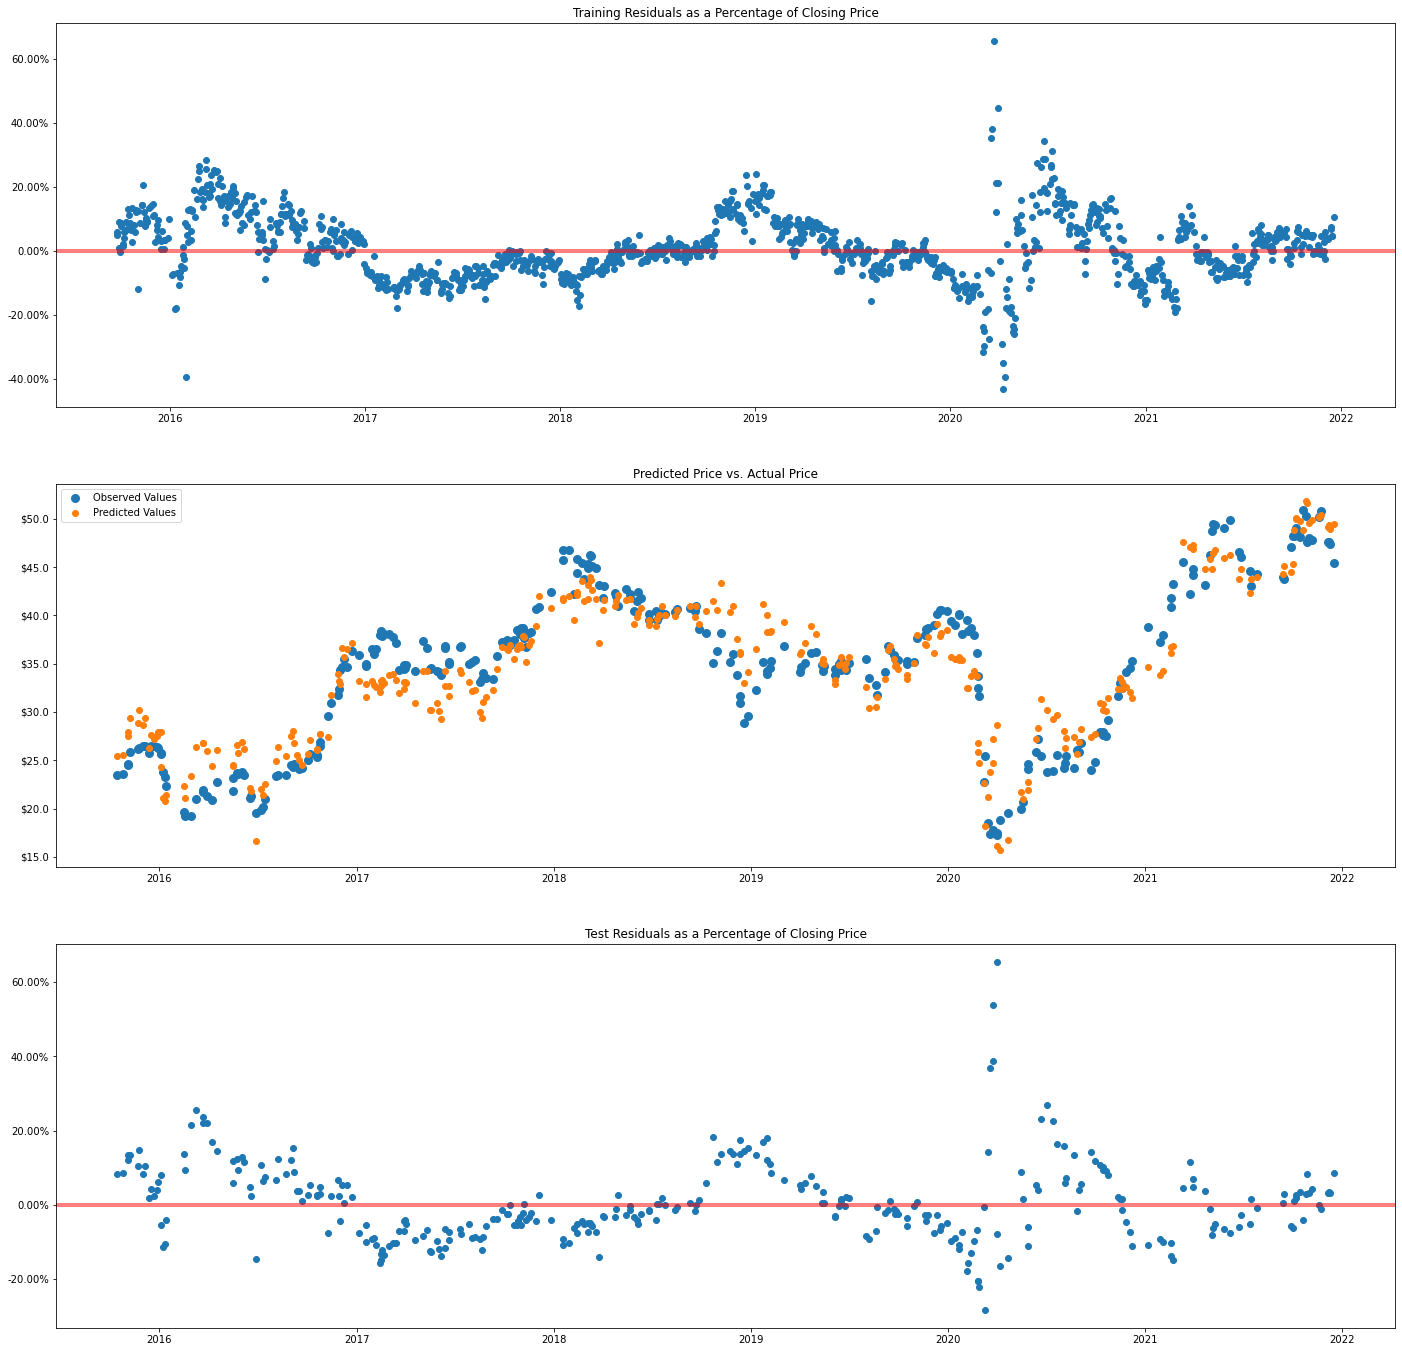

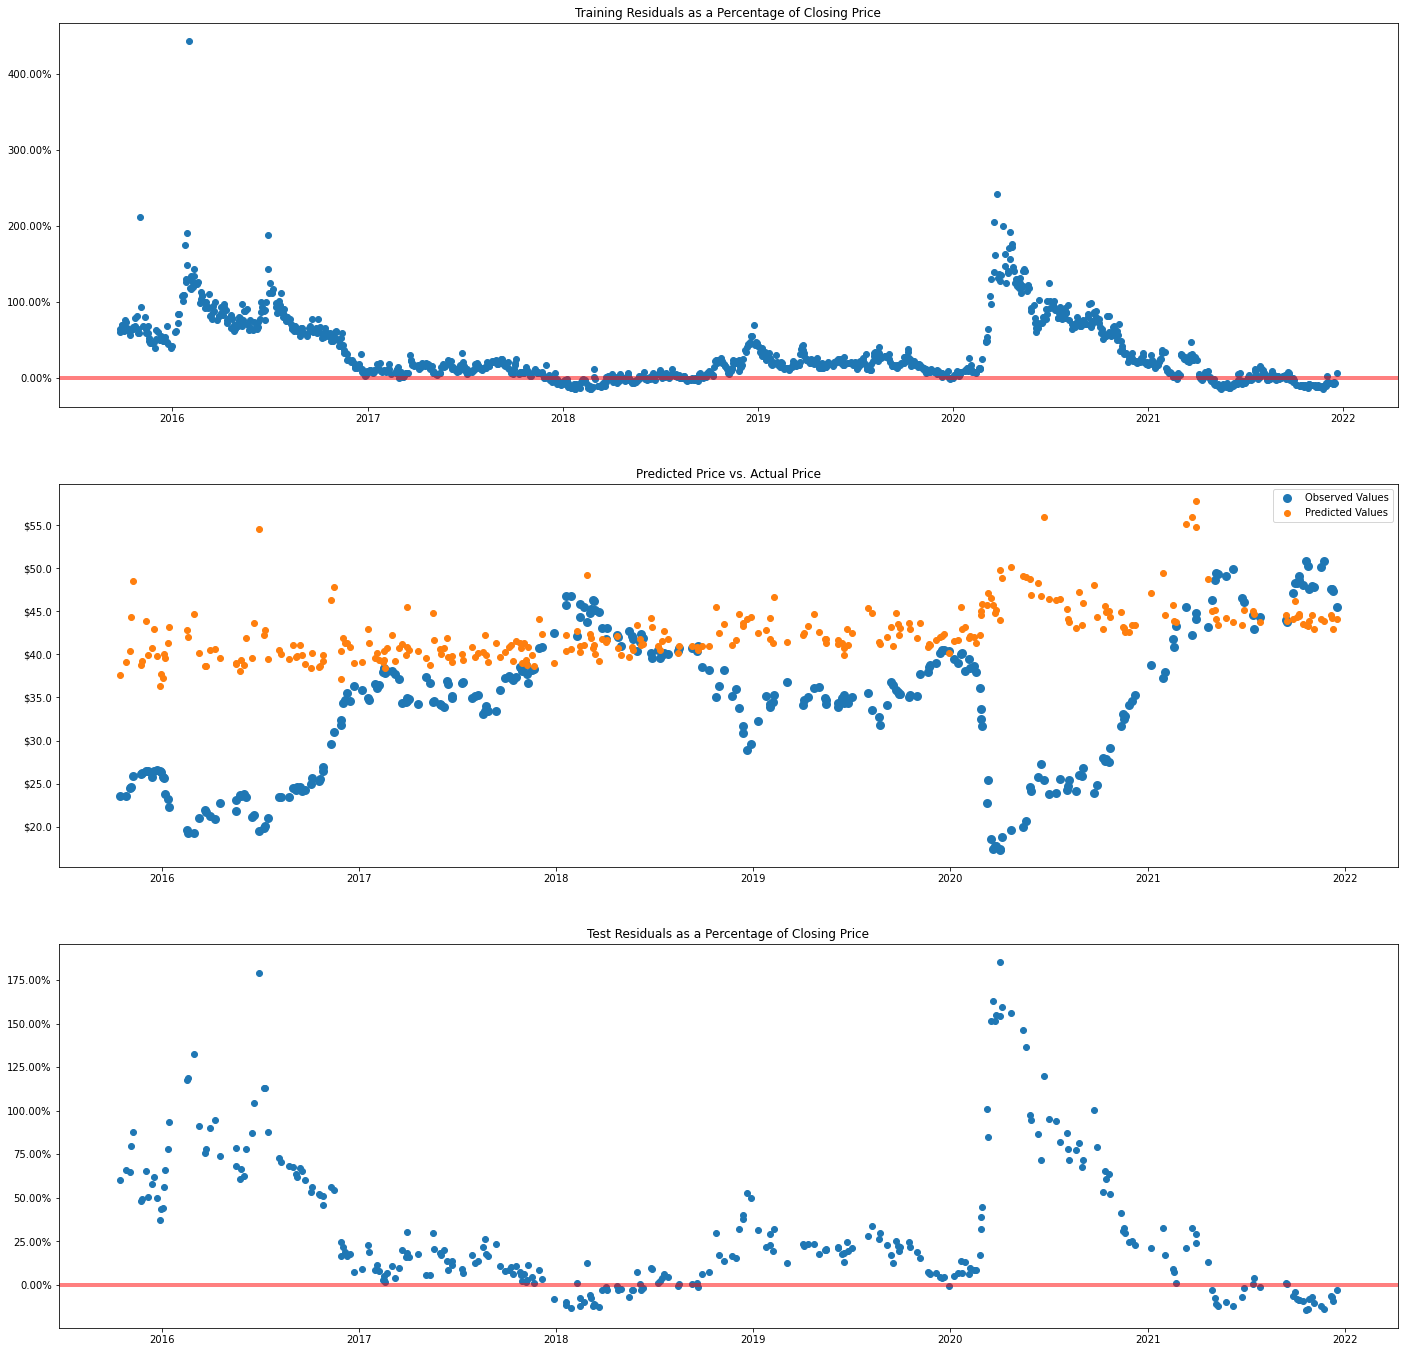

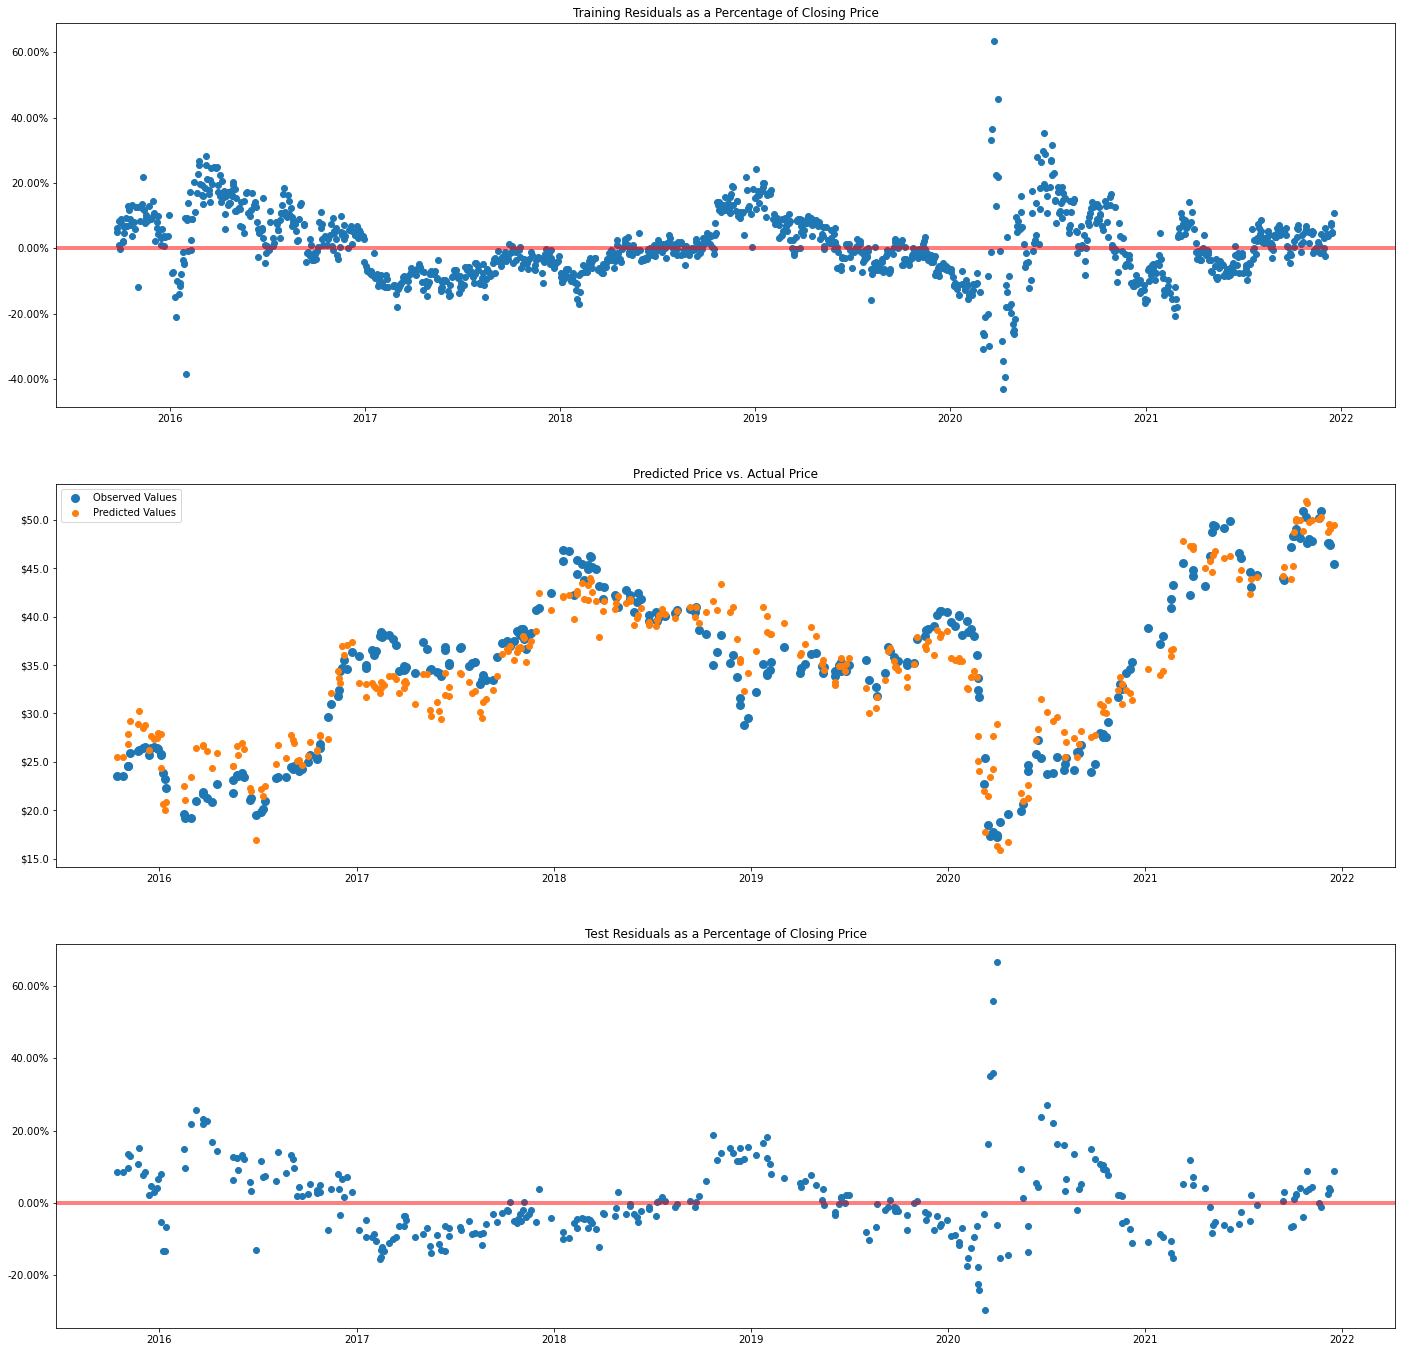

In [14]:
X_train, X_test, y_train, y_test = preprocess_data(df)
en_results = EN_test(X_train, X_test, y_train, y_test)
svr_results = SVR_test(X_train, X_test, y_train, y_test)
ridge_results = Ridge_test(X_train, X_test, y_train, y_test)